In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
mpl.rcParams.update({"font.size": 16})
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

In [65]:
tf.__version__

'2.4.1'

In [5]:
import tqdm
import glob

In [6]:
import wispy.mscalev3

In [7]:
from tensorflow.keras.utils import get_custom_objects
import pugna.activations
get_custom_objects().update({'s2relu': pugna.activations.s2relu})

In [8]:
def gen_data(npoints=201, x_start=-2, x_end=2):
    """
    generate a wave which is a superposition of two
    sine-waves at 1Hz and 4Hz
    """
    x = np.linspace(x_start, x_end, npoints)[:,np.newaxis]
    
    f = 1
    om = 2*np.pi*f
    y1 = np.sin(om*x)
    
    f = 4
    om = 2*np.pi*f
    y2 = np.sin(om*x)
    
    #f = 8
    #om = 2*np.pi*f
    #y3 = np.sin(om*x)
    
    y = y1 + y2 #+ y3
    return x, y, y1, y2

In [9]:
x, y, _, _ = gen_data(npoints=101) 

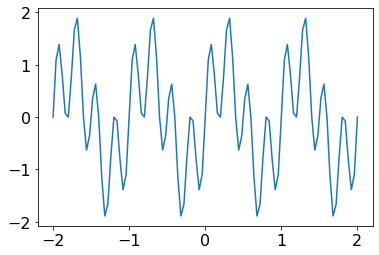

In [10]:
plt.figure()
plt.plot(x, y)

In [11]:
x.shape

(101, 1)

In [12]:
y.shape

(101, 1)

In [13]:
def get_uncompiled_model(
    input_shape=1,
    output_shape=1,
    units=[128],
    activation="relu",
    n_blocks=[2],
    scales=[1],
    layers_per_block=3,
    scale_dimension=0,
    dtype=None,):
    
    
    model = wispy.mscalev3.build_model(
        input_shape=input_shape,
        output_shape=output_shape,
        units=units,
        activation=activation,
        n_blocks=n_blocks,
        scales=scales,
        layers_per_block=layers_per_block,
        scale_dimension=scale_dimension,
        dtype=dtype,
    )
    
    return model

In [14]:
def get_compiled_model(
    input_shape=1,
    output_shape=1,
    units=[128,128],
    activation="s2relu",
    n_blocks=[2,2],
    scales=[1, 10],
    layers_per_block=3,
    scale_dimension=0,
    dtype=None,):
    model = get_uncompiled_model(
        input_shape=input_shape,
        output_shape=output_shape,
        units=units,
        activation=activation,
        n_blocks=n_blocks,
        scales=scales,
        layers_per_block=layers_per_block,
        scale_dimension=scale_dimension,
        dtype=dtype,
    )
    
    optimizer = tf.keras.optimizers.Adam(1e-3, amsgrad=True)
    
    model.compile(loss="mse", optimizer=optimizer)
    
    return model

In [15]:
model = get_compiled_model()

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
scale_layer (ScaleLayer)        (None, 1)            0           input_1[0][0]                    
__________________________________________________________________________________________________
scale_layer_1 (ScaleLayer)      (None, 1)            0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          256         scale_layer[0][0]                
______________________________________________________________________________________________

In [17]:

# https://medium.com/@bechr7/learning-rate-scheduling-with-callbacks-in-tensorflow-e2ba83647013

# Define configuration parameters
start_lr = 0.001
rampup_epochs = 1500
exp_decay = 0.001

# Define the scheduling function
def schedule(epoch):
    def lr(epoch, start_lr, rampup_epochs, exp_decay):
        if epoch < rampup_epochs:
            return start_lr
        else:
            return start_lr * tf.math.exp(-exp_decay * epoch)
    return lr(epoch, start_lr, rampup_epochs, exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(schedule, verbose=False)

callbacks=[lr_callback]

# callbacks=None

In [18]:
%%time
history = model.fit(x, y, epochs=3000, verbose=0, callbacks=callbacks)

CPU times: user 51.9 s, sys: 6.57 s, total: 58.5 s
Wall time: 20.3 s


In [19]:
list(history.history)

['loss', 'lr']

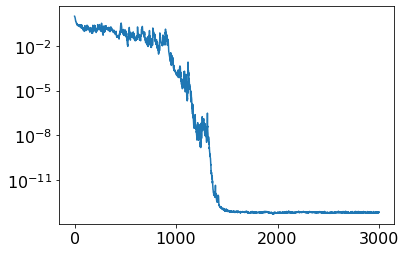

In [20]:
plt.figure()
plt.plot(history.history['loss'])
plt.yscale('log')

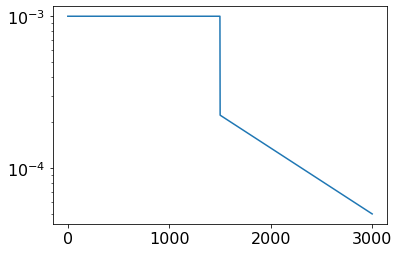

In [21]:
plt.figure()
plt.plot(history.history['lr'])
plt.yscale('log')
# plt.xscale('log')

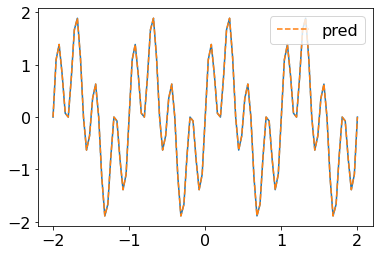

In [22]:
plt.figure()
plt.plot(x, y)
plt.plot(x, model(x), label='pred', ls='--')
plt.legend()

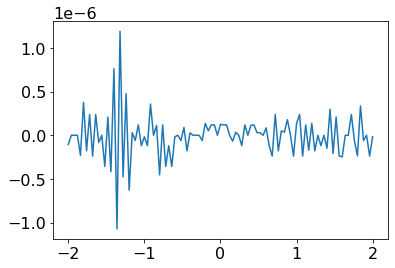

In [24]:
plt.figure()
plt.plot(x, y-model(x))


# tfrecords

In [25]:
# https://www.tensorflow.org/tutorials/load_data/tfrecord#tfrecord_files_in_python


# https://towardsdatascience.com/a-practical-guide-to-tfrecords-584536bc786c
# https://colab.research.google.com/drive/1xU_MJ3R8oj8YYYi-VI_WJTU3hD1OpAB7?usp=sharing#scrollTo=rmTv61HFAv57

In [26]:
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [27]:
print(_float_feature(np.random.uniform(size=(1, 4))))

TypeError: array([[0.32493646, 0.01343419, 0.43783794, 0.76353234]]) has type numpy.ndarray, but expected one of: int, long, float

In [28]:
print(_float_feature(np.float16(1.03)))
print(_float_feature(np.float32(1.03)))
print(_float_feature(np.float64(1.03)))

print(_float_feature(np.float16(1.03)).SerializeToString())
print(_float_feature(np.float32(1.03)).SerializeToString())
print(_float_feature(np.float64(1.03)).SerializeToString())

float_list {
  value: 1.0302734375
}

float_list {
  value: 1.0299999713897705
}

float_list {
  value: 1.0299999713897705
}

b'\x12\x06\n\x04\x00\xe0\x83?'
b'\x12\x06\n\x04\n\xd7\x83?'
b'\x12\x06\n\x04\n\xd7\x83?'


In [29]:
x.shape

(101, 1)

In [30]:
features_dataset = tf.data.Dataset.from_tensor_slices((x, y))

In [31]:
features_dataset

<TensorSliceDataset shapes: ((1,), (1,)), types: (tf.float64, tf.float64)>

In [32]:
for f0,f1 in features_dataset.take(1):
    print(f0)
    print(f1)

tf.Tensor([-2.], shape=(1,), dtype=float64)
tf.Tensor([2.4492936e-15], shape=(1,), dtype=float64)


In [33]:
x[0]

array([-2.])

In [34]:
y[0]

array([2.4492936e-15])

In [35]:
def parse_single_image(features, targets):
    """
    features: X_train
    targets: y_train
    """
  
    #define the dictionary -- the structure -- of our single example
    data = {
        'x' : _float_feature(features),
        'y' : _float_feature(targets)
    }

    #create an Example, wrapping the single features
    out = tf.train.Example(features=tf.train.Features(feature=data))

    return out

In [36]:
(101//2) + 1

51

In [37]:
def write_training_data_to_sharded_tf_record(features, targets, filename:str="test-records", max_samples_per_shard:int=10, out_dir:str="./"):
    """
    features: X_train
    targets: y_train
    """

    num_samples = len(features)
    
    #determine the number of shards (single TFRecord files) we need:
    splits = (num_samples//max_samples_per_shard) + 1 #determine how many tfr shards are needed
    if num_samples%max_samples_per_shard == 0:
        splits-=1
    print(f"\nUsing {splits} shard(s) for {num_samples} samples, with up to {max_samples_per_shard} samples per shard")

    file_count = 0

    for i in tqdm.tqdm(range(splits)):
        current_shard_name = "{}{}_{}_{}.tfrecords".format(out_dir, i+1, splits, filename)
        writer = tf.io.TFRecordWriter(current_shard_name)

        current_shard_count = 0
        while current_shard_count < max_samples_per_shard: #as long as our shard is not full
            #get the index of the file that we want to parse now
            index = i*max_samples_per_shard+current_shard_count
            if index == num_samples: #when we have consumed the whole data, preempt generation
                break
      
            current_targets = targets[index]
            current_features = features[index]

            #create the required Example representation
            out = parse_single_image(features=current_features, targets=current_targets)
    
            writer.write(out.SerializeToString())
            current_shard_count+=1
            file_count += 1

        writer.close()
    print(f"\nWrote {file_count} elements to TFRecord")
    return file_count

In [41]:
write_training_data_to_sharded_tf_record(features=x, targets=y, max_samples_per_shard=10)

100%|██████████| 11/11 [00:00<00:00, 2070.80it/s]


Using 11 shard(s) for 101 samples, with up to 10 samples per shard

Wrote 101 elements to TFRecord


101

In [42]:
!ls

10_11_test-records.tfrecords 7_11_test-records.tfrecords
11_11_test-records.tfrecords 8_11_test-records.tfrecords
1_11_test-records.tfrecords  9_11_test-records.tfrecords
2_11_test-records.tfrecords  dev.ipynb
3_11_test-records.tfrecords  model.png
4_11_test-records.tfrecords  mpi-array-example
5_11_test-records.tfrecords  mpi-example
6_11_test-records.tfrecords  nd-tfrecords.ipynb


In [43]:
def parse_tfr_element(element):
    #use the same structure as above; it's kinda an outline of the structure we now want to create
    data = {
      'x': tf.io.FixedLenFeature([], tf.float32),
      'y': tf.io.FixedLenFeature([], tf.float32),
    }

    content = tf.io.parse_single_example(element, data)

    x = content['x']
    y = content['y']


    #get our 'feature'-- our image -- and reshape it appropriately
#     feature = tf.io.parse_tensor(y, out_type=tf.float32)
#     label = tf.io.parse_tensor(x, out_type=tf.float32)
#     return (feature, label)
    return (x, y)


In [44]:
def get_dataset_large(tfr_dir:str="./", pattern:str="*test-records.tfrecords"):
    print(tfr_dir+pattern)
    files = glob.glob(tfr_dir+pattern, recursive=False)
    print(files)

    #create the dataset
    dataset = tf.data.TFRecordDataset(files)

    #pass every single feature through our mapping function
    dataset = dataset.map(
        parse_tfr_element
    )
    
    return dataset

In [45]:
dataset_large = get_dataset_large()

./*test-records.tfrecords
['./2_11_test-records.tfrecords', './10_11_test-records.tfrecords', './5_11_test-records.tfrecords', './8_11_test-records.tfrecords', './7_11_test-records.tfrecords', './6_11_test-records.tfrecords', './1_11_test-records.tfrecords', './9_11_test-records.tfrecords', './4_11_test-records.tfrecords', './3_11_test-records.tfrecords', './11_11_test-records.tfrecords']


In [46]:
!du -sch *.tfrecords

4.0K	10_11_test-records.tfrecords
4.0K	11_11_test-records.tfrecords
4.0K	1_11_test-records.tfrecords
4.0K	2_11_test-records.tfrecords
4.0K	3_11_test-records.tfrecords
4.0K	4_11_test-records.tfrecords
4.0K	5_11_test-records.tfrecords
4.0K	6_11_test-records.tfrecords
4.0K	7_11_test-records.tfrecords
4.0K	8_11_test-records.tfrecords
4.0K	9_11_test-records.tfrecords
 44K	total


In [47]:
dataset_large

<MapDataset shapes: ((), ()), types: (tf.float32, tf.float32)>

In [48]:
# dataset_large = dataset_large.shuffle(buffer_size=32)
dataset_large = dataset_large.shuffle(5000).batch(32)

In [49]:
for sample in dataset_large.take(2):
    print(sample[0])
    print(sample[1])

tf.Tensor(
[-1.36 -0.84  1.32 -0.16 -0.68  0.88 -0.12  2.    1.04 -0.92 -0.64 -1.
 -0.36  0.16 -0.08  0.2  -1.76 -0.76  1.56 -0.44 -1.88 -1.32 -1.4  -0.72
 -1.72  0.28  0.48 -1.08 -0.2  -0.4   0.24 -1.56], shape=(32,), dtype=float32)
tf.Tensor(
[-1.1386378e+00  7.3814683e-02  1.8871143e+00 -7.3814683e-02
  1.8871143e+00 -8.0988032e-01 -8.0988032e-01 -2.4492936e-15
  1.0930178e+00  1.3865807e+00  1.1386378e+00  1.2246468e-15
 -1.1386378e+00  7.3814683e-02 -1.3865807e+00  1.5543122e-15
  7.4933684e-01  7.4933684e-01  6.2990218e-01  6.2990218e-01
  8.0988032e-01 -1.8871143e+00 -1.3322676e-15  1.6668344e+00
  1.6668344e+00  1.6668344e+00 -3.5642043e-01 -1.3865807e+00
  3.3306691e-16 -2.2204460e-15  7.4933684e-01 -6.2990218e-01], shape=(32,), dtype=float32)
tf.Tensor(
[-1.64  0.6  -1.84  1.96  1.76  0.92  1.44 -1.24  0.04  1.08 -1.8  -1.16
  0.08 -0.96 -1.68  0.36  0.52  1.48  1.68  1.52  1.6  -0.6   1.92  0.44
  1.64 -1.28 -0.52  0.    1.24 -1.92 -0.56 -0.28], shape=(32,), dtype=float32)
t

In [50]:
x[0:2]

array([[-2.  ],
       [-1.96]])

In [51]:
y[0:2]

array([[2.44929360e-15],
       [1.09301781e+00]])

In [71]:
model = get_compiled_model()

In [72]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
scale_layer_6 (ScaleLayer)      (None, 1)            0           input_4[0][0]                    
__________________________________________________________________________________________________
scale_layer_7 (ScaleLayer)      (None, 1)            0           input_4[0][0]                    
__________________________________________________________________________________________________
dense_58 (Dense)                (None, 128)          256         scale_layer_6[0][0]              
____________________________________________________________________________________________

In [73]:

# https://medium.com/@bechr7/learning-rate-scheduling-with-callbacks-in-tensorflow-e2ba83647013

# Define configuration parameters
start_lr = 0.001
rampup_epochs = 1500
exp_decay = 0.001

# Define the scheduling function
def schedule(epoch):
    def lr(epoch, start_lr, rampup_epochs, exp_decay):
        if epoch < rampup_epochs:
            return start_lr
        else:
            return start_lr * tf.math.exp(-exp_decay * epoch)
    return lr(epoch, start_lr, rampup_epochs, exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(schedule, verbose=False)

callbacks=[lr_callback]

# callbacks=None

In [74]:
%%time
history = model.fit(dataset_large, epochs=3000, verbose=1, callbacks=callbacks)

Epoch 1/3000
4/4 [==============================] - 1s 3ms/step - loss: 0.9745
Epoch 2/3000
4/4 [==============================] - 0s 2ms/step - loss: 0.9627
Epoch 3/3000
4/4 [==============================] - 0s 2ms/step - loss: 0.8514
Epoch 4/3000
4/4 [==============================] - 0s 2ms/step - loss: 0.8033
Epoch 5/3000
4/4 [==============================] - 0s 2ms/step - loss: 0.6707
Epoch 6/3000
4/4 [==============================] - 0s 3ms/step - loss: 0.5843
Epoch 7/3000
4/4 [==============================] - 0s 2ms/step - loss: 0.5507
Epoch 8/3000
4/4 [==============================] - 0s 2ms/step - loss: 0.5184
Epoch 9/3000
4/4 [==============================] - 0s 2ms/step - loss: 0.4879
Epoch 10/3000
4/4 [==============================] - 0s 2ms/step - loss: 0.4613
Epoch 11/3000
4/4 [==============================] - 0s 2ms/step - loss: 0.4463
Epoch 12/3000
4/4 [==============================] - 0s 2ms/step - loss: 0.4053
Epoch 13/3000
4/4 [==============================

In [75]:
list(history.history)

['loss', 'lr']

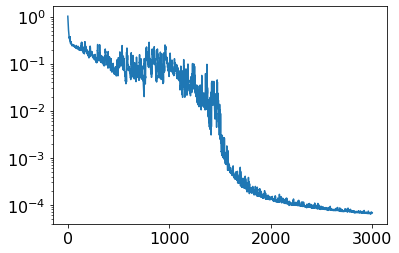

In [67]:
plt.figure()
plt.plot(history.history['loss'])
plt.yscale('log')

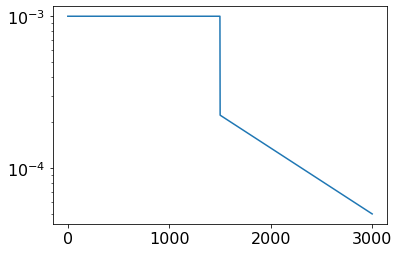

In [68]:
plt.figure()
plt.plot(history.history['lr'])
plt.yscale('log')
# plt.xscale('log')

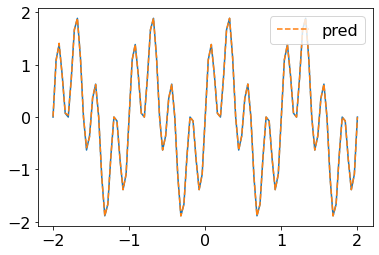

In [69]:
plt.figure()
plt.plot(x, y)
plt.plot(x, model(x), label='pred', ls='--')
plt.legend()

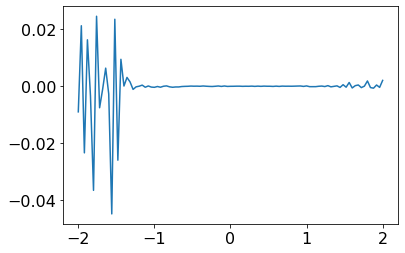

In [70]:
plt.figure()
plt.plot(x, y-model(x))